<a href="https://colab.research.google.com/github/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 - Упакованные дополненные последовательности, маскирование, вывод и метод оценки BLEU

## Введение

В этой части мы добавим несколько улучшений — упакованные дополненные последовательности и маскирование — к модели из предыдущего раздела. Упакованные дополненные последовательности используются, чтобы сообщить нашей RNN, что нужно пропускать маркеры заполнения в нашем кодировщике. Маскирование явно заставляет модель игнорировать определенные значения, такие как внимание к элементам с заполнением. Оба эти метода обычно используются в обработке естественного языка (NLP).

Кроме того, мы рассмотрим как использовать нашу модель для вывода целевого предложения, давая ей входное предложение, видя результат её перевода, и выясняя, на что именно она обращает внимание при переводе каждого слова.

Наконец, мы будем использовать метрику BLEU для измерения качества наших переводов.

## Подготовка данных

Сначала мы импортируем все модули, как и раньше, с добавлением модулей `matplotlib`, используемых для просмотра вектора внимания.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

Затем мы установим случайное начальное число для воспроизводимости.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Загрузите немецкую и английскую модели spaCy.

```
python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm
```

Для загрузки в Google Colab используем следующие команды (После загрузки обязательно перезапустите colab runtime! Наибыстрейший способ через короткую комаду： **Ctrl + M + .**):

In [ ]:
!pip install -U spacy==3.0
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Как и раньше, мы импортируем spaCy и определим токенизаторы для немецкого и английского языков.

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

При использовании упакованных дополненных последовательностей нам нужно сообщить PyTorch, какова длина фактических (не дополненных) последовательностей. К счастью для нас, объекты TorchText `Field` позволяют нам использовать аргумент` include_lengths`, это приведет к тому, что наш `batch.src` будет кортежем. Первый элемент кортежа такой же, как и раньше, пакет числовых исходных предложений в качестве тензора, а второй элемент — это длины без дополнений каждого исходного предложения в пакете.

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Затем мы загружаем данные.

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

И заполняем словарь.

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Далее мы подготавливаем итераторы.

Одна из особенностей упакованных последовательностей с дополнениями заключается в том, что все элементы (предложения) в пакете должны быть отсортированы по их длине без дополнений в порядке убывания, т.е. первое предложение в пакете должно быть самым длинным. Мы используем два аргумента итератора для обработки этого: `sort_within_batch`, который сообщает итератору, что содержимое пакета необходимо отсортировать, и `sort_key` - функцию, которая сообщает итератору, как сортировать элементы в пакете. Здесь мы сортируем по длине предложения `src`.

In [8]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

## Построение модели

### Кодировщик

Далее мы определяем кодировщик.

Все изменения здесь происходят в методе `forward`. Теперь он принимает длину исходных предложений и сами предложения.

После того, как исходное предложение (автоматически дополненное итератором) было пропущено через эмбеддинг, мы можем использовать для него `pack_padded_sequence` с длинами предложений. Обратите внимание, что тензор, содержащий длины последовательностей, должен быть тензором CPU в последней версии PyTorch, что мы явно делаем с помощью `to ('cpu')`. `Packaged_embedded` будет нашей упакованной последовательностью. Затем передаём в нашу RNN как обычно, и она возвращает `packed_outputs`, упакованный тензор, содержащий все скрытые состояния из последовательности, и `hidden` - это просто последнее скрытое состояние из нашей последовательности. `hidden` стандартный тензор и никак не упакованный, единственная разница в том, что на входе была упакованная последовательность, этот тензор из последнего **элемента без дополнений** в последовательности.

Затем мы распаковываем наши `packed_outputs` с использованием `pad_packed_sequence` который возвращает `outputs` и длины каждого, которые нам не нужны.

Первое измерение `outputs` - это длины дополненных последовательностей.  Однако из-за использования упакованной дополненной последовательности значения тензоров будут нулевыми, в случае когда на входе был маркер заполнения.

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Внимание

Модуль внимания — это та часть, в которой мы вычисляем значения внимания по исходному предложению.

Ранее мы позволяли этому модулю «обращать внимание» на токены заполнения в исходном предложении. Однако, используя *маскировку*, мы можем заставить внимание концентрироваться только на элементах, не являющиеся заполнением.

Метод `forward` теперь принимает на входе `mask`. Это тензор **[batch size, source sentence length]**, который равен 1, если токен исходного предложения не является токеном заполнения, и 0, когда это маркер заполнения. Например, если исходное предложение ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], то маска будет [1, 1, 1, 1, 1, 0, 0].

Мы применяем маску после того, как внимание было рассчитано, но до того, как оно будет нормализовано функцией `softmax`. Это реализовано с использованием `masked_fill`. Тензор заполняется для каждого элемента, для которого выполняется условие для первого аргумента `mask == 0`, значением, заданным вторым аргументом ` -1e10`. Другими словами, он примет ненормализованные значения внимания и изменит их для элементов заполнения на`-1e10`. Поскольку эти числа будут мизерными по сравнению с другими значениями, они станут равными нулю при прохождении через слой `softmax`, что гарантирует отсутствие внимания к маркерам заполнения в исходном предложении.

In [10]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Декодер

В декодере нужно внести лишь несколько небольших изменений. Ему необходимо принять маску исходного предложения и передать ее модулю внимания. Поскольку мы хотим просмотреть значения внимания во время вывода, мы возвращаем и тензор внимания.

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

Общая модель seq2seq нуждается в некоторых изменениях для упакованных дополненных последовательностей, маскирования и логического вывода.

Нам нужно сообщить модели, каковы индексы для токена заполнения, а также передать длину исходного предложения в качестве входных данных в метод `forward`.

Мы используем индекс токена заполнения для создания масок, создавая тензор маски, равный 1, везде, где исходное предложение не равно токену заполнения. Все это делается с помощью функции `create_mask`.

Длины последовательностей, которые необходимо передать кодеру для использования упакованных дополненных последовательностей.

Внимание на каждом временном шаге сохраняется в `attentions`

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Обучение модели Seq2Seq

Затем инициализируем модель и размещаем ее на GPU.

In [13]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

Затем мы инициализируем параметры модели.

In [14]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Мы распечатаем количество обучаемых параметров в модели, заметив, что она имеет точно такое же количество параметров, что и модель без улучшений.

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


Затем мы определяем наш оптимизатор и критерий оптимизации.

`ignore_index` для критерия должен быть индексом токена заполнения для целевого языка, но не для исходного.

In [16]:
optimizer = optim.Adam(model.parameters())

In [17]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Далее мы определим наши циклы обучения и оценки.

Поскольку мы используем `include_lengths = True` для нашего исходного поля,` batch.src` теперь является кортежем, первый элемент которого представляет собой числовой тензор, представляющий предложение, а второй элемент — длины каждого предложения в пакете.

Наша модель возвращает, в том числе, векторы внимания для батча исходных предложений на каждом временном шаге декодирования. Мы не будем использовать их во время обучения и оценки точности обучения, но мы будем использовать их позже для вывода.


Для отображения прогресса в Google Colab устанавливаем tensorboard

In [ ]:
!pip install tensorboardX

In [19]:
from tensorboardX import SummaryWriter
import datetime

#  Load the TensorBoard notebook extension
%load_ext tensorboard

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Затем мы определим функцию для определения продолжительности эпох.

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Запускаем tensorboard. Отображение данных начнётся после запуска обучения. Обновить данные можно кликнув по иконке справа вверху

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/
%tensorboard --logdir runs

Предпоследний шаг — обучить нашу модель. Обратите внимание, что это занимает только почти половину времени по сравнению с нашей моделью без улучшений, добавленных в этот раздел.

In [24]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
writer = SummaryWriter()

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    writer.add_scalar("Train Loss", train_loss, epoch+1)
    writer.add_scalar("Train PPL", math.exp(train_loss), epoch+1)
    writer.add_scalar("Val. Loss", valid_loss, epoch+1)
    writer.add_scalar("Val. PPL", math.exp(valid_loss), epoch+1)

writer.close()

Epoch: 01 | Time: 0m 45s
	Train Loss: 5.042 | Train PPL: 154.803
	 Val. Loss: 4.786 |  Val. PPL: 119.857
Epoch: 02 | Time: 0m 46s
	Train Loss: 4.105 | Train PPL:  60.633
	 Val. Loss: 4.193 |  Val. PPL:  66.236
Epoch: 03 | Time: 0m 46s
	Train Loss: 3.361 | Train PPL:  28.823
	 Val. Loss: 3.622 |  Val. PPL:  37.423
Epoch: 04 | Time: 0m 46s
	Train Loss: 2.873 | Train PPL:  17.688
	 Val. Loss: 3.366 |  Val. PPL:  28.975
Epoch: 05 | Time: 0m 46s
	Train Loss: 2.485 | Train PPL:  12.006
	 Val. Loss: 3.246 |  Val. PPL:  25.690
Epoch: 06 | Time: 0m 46s
	Train Loss: 2.189 | Train PPL:   8.924
	 Val. Loss: 3.252 |  Val. PPL:  25.854
Epoch: 07 | Time: 0m 46s
	Train Loss: 1.957 | Train PPL:   7.076
	 Val. Loss: 3.125 |  Val. PPL:  22.768
Epoch: 08 | Time: 0m 46s
	Train Loss: 1.755 | Train PPL:   5.784
	 Val. Loss: 3.268 |  Val. PPL:  26.257
Epoch: 09 | Time: 0m 46s
	Train Loss: 1.598 | Train PPL:   4.941
	 Val. Loss: 3.246 |  Val. PPL:  25.700
Epoch: 10 | Time: 0m 46s
	Train Loss: 1.486 | Train PPL

Наконец, мы загружаем параметры из нашей лучшей модели и проводим проверку на тестовом наборе.

Мы получаем модель с лучшими результатами, но при этом почти вдвое быстрее!

In [25]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.149 | Test PPL:  23.301 |


## Вывод

Теперь мы можем использовать нашу обученную модель для создания переводов.

**Примечание:** эти переводы будут хуже, чем показанные в статье, поскольку авторы в статье использовали скрытые размеры 1000 и тренировали модеь в течение 4 дней! Они были подобраны для того, чтобы продемонстрировать, как должно выглядеть внимание на модели достаточно большого размера.

Наш `translate_sentence` будет делать следующее:
- убедится, что наша модель находится в режиме оценки, который всегда должен быть включён для вывода
- токенизируем исходное предложение, если оно не было токенизировано (является строкой)
- "оцифрует" исходное предложение
- преобразует его в тензор и добавить размер батча
- получит длину исходного предложения и преобразует его в тензор
- передаст исходное предложение в кодировщик
- создаст маску для исходного предложения
- создаст список для хранения выходного предложения, инициализированного токеном `<sos>`
- создаст тензор для удержания значений внимания
- пока мы не достигли максимальной длины
  - получит входной тензор, который должен быть либо `<sos>`, либо последним предсказанным токеном
  - передаст входной тензор, все выходы кодировщика, скрытое состояние и маску в декодер
  - сохранит значения внимания
  - получит предсказанный следующий токен
  - добавит предсказание к предсказанию текущего выходного предложения
  - прервёт выполнение, если предсказание было токеном `<eos>`
- преобразует выходное предложение из индексов в токены
- вернёт выходное предложение (с удаленным токеном `<sos>`) и значения внимания для последовательности

In [26]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

Затем мы создадим функцию, которая отображает внимание модели к исходному предложению для каждого сгенерированного целевого токена.

In [27]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Теперь мы возьмем несколько переводов из нашего набора данных и посмотрим, насколько хорошо работает наша модель. Обратите внимание: здесь мы собираемся выбрать некоторые рафинированные примеры, чтобы было что-то интересное, но не стесняйтесь изменять значение `example_idx`, чтобы посмотреть на другие примеры.

Сначала мы получим исходное и целевое предложения из нашего набора данных.

In [28]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


Затем мы воспользуемся функцией `translate_sentence`, чтобы получить предсказанный перевод и внимание. Мы показываем это графически, располагая исходное предложение на оси x и прогнозируемый перевод на оси y. Чем светлее квадрат на пересечении двух слов, тем больше внимания модель уделяла этому исходному слову при переводе этого целевого слова.

Ниже приведен пример, который модель пыталась перевести, она получает правильный перевод, за исключением некоторых слов.

In [29]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'fighting', '.', '<eos>']


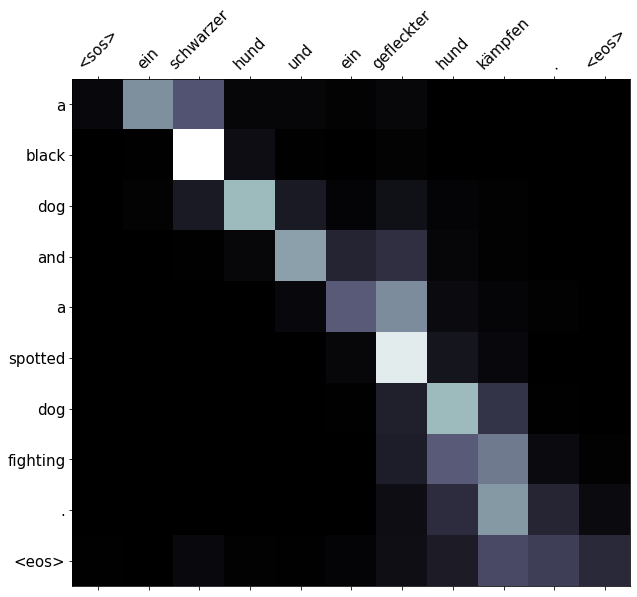

In [30]:
display_attention(src, translation, attention)

Переводы из обучающей выборки модель могла просто запомнить. Так что справедливо, что мы также смотрим на переводы из набора для проверки и тестирования.

Начнем с набора для проверки, давайте рассмотрим пример.

In [31]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


Затем сгенерируем наш перевод и просмотрим внимание.

Здесь мы видим, что перевод такой же, за исключением замены *female* на *woman*.

predicted trg = ['a', 'woman', 'plays', 'a', 'song', 'on', 'the', 'floor', '.', '<eos>']


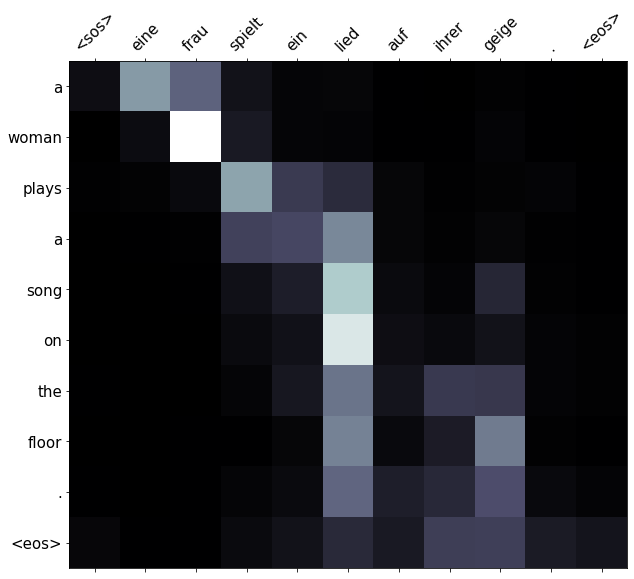

In [32]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

Finally, let's get an example from the test set.

In [33]:
example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['die', 'person', 'im', 'gestreiften', 'shirt', 'klettert', 'auf', 'einen', 'berg', '.']
trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']


Again, it produces a slightly different translation than target, a more literal version of the source sentence. It swaps *mountain climbing* for *climbing a mountain*.

predicted trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'climbing', 'a', 'mountain', '.', '<eos>']


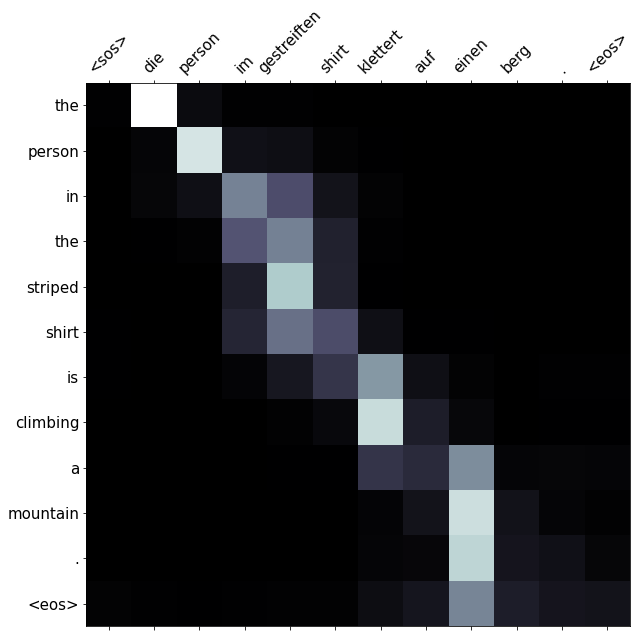

In [34]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

## BLEU

Раньше мы заботились только о потерях/достоверности модели. Однако есть показатели, специально разработанные для измерения качества перевода. Наиболее популярным из них является *BLEU*. Не вдаваясь в подробности, BLEU рассматривает совпадение предсказанных и фактических целевых последовательностей с точки зрения их n-грамм. Он даст нам число от 0 до 1 для каждой последовательности, где 1 означает полное совпадение, то есть идеальный перевод (хотя обычно отображают в процентах от 0 до 100). BLEU был разработан для работы с несколькими кандидатами переводов для каждой исходной последовательности, однако в нашем наборе данных у есть только один кандидат.

Мы определяем функцию `calculate_bleu`, которая вычисляет оценку BLEU по предоставленному набору данных TorchText. Эта функция создает корпус фактического и прогнозируемого перевода для каждого исходного предложения, а затем вычисляет оценку BLEU.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

Мы получаем BLEU около 28. Если мы сравним этот результат со статьёй, из которой пытаемся воспроизвести модель с внимания, то там авторы достигают 26,75 балла по шкале BLEU. Это похоже на нашу оценку, однако они используют совершенно другой набор данных, а размер их модели намного больше - 1000 скрытых состояний, обучение которых занимает 4 дня! - так что мы не можем сравнивать результаты с ними.

Это число на самом деле не поддается интерпретации, мы не можем сказать о нем много. Самая полезная часть оценки BLEU заключается в том, что её можно использовать для сравнения разных моделей в одном наборе данных, где модель с более высокой оценкой BLEU «лучше».

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.88


В следующих частях мы отойдем от использования рекуррентных нейронных сетей и начнем искать другие способы построения моделей sequence-to-sequence. В частности, в следующей части мы будем использовать свёрточные нейронные сети.

In [35]:
!nvidia-smi

Thu Jun 10 06:37:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   5478MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------